# Classifying Business Documents using Deep Learning
## IBM Coursera Advanced Data Science Capstone - Model Building

## Sumudu Tennakoon


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 16 2019

@author: Sumudu Tennakoon
@licence:Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)
"""

import pandas as pd
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt 
from datetime import date
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
print('TensorFlow Version: ', tf.__version__)

from DocumentClassifierV1 import * # Custom library created for the Capstone project.

TensorFlow Version:  1.12.0


## 1. Read Pre-saved Input dataset

In [2]:
DocumentFilesData  = pd.read_pickle('Data/DocumentClassification_IBM_ADV_DS_Capstone_TrainSample_128x128_20190316.pkl')

In [3]:
ClassLabels = list(DocumentFilesData.FileClass.unique()) 

In [4]:
ClassNumbers = list(range(len(ClassLabels)))

In [5]:
ClassLabelMap = list((zip(ClassLabels, ClassNumbers)))
print(ClassLabelMap)

[('advertisement', 0), ('handwritten', 1), ('invoice', 2), ('letter', 3), ('resume', 4), ('scientific publication', 5)]


In [6]:
for clm in ClassLabelMap:
    DocumentFilesData.loc[DocumentFilesData['FileClass']==clm[0] , 'ClassNumber'] = clm[1]

In [7]:
NClasses = len(ClassLabels)
imgRows = 128
imgCols = 128  

## 2. Pre-Process Modeling Dataset

In [8]:
TestSize= 0.3
ResponseColumn='ClassNumber'

TrainData, TestData = train_test_split(DocumentFilesData, test_size=TestSize, random_state=42)
x_train = TrainData['DocumentMatrix'].values
x_train = np.asarray(list(x_train), dtype ='int')
y_train = TrainData[ResponseColumn].values
x_test = TestData['DocumentMatrix'].values
x_test = np.asarray(list(x_test), dtype ='int')
y_test = TestData[ResponseColumn].values        

In [9]:
#Modeling parameters    
NClasses = len(ClassLabels)

#Shape of datasets
print(x_train.shape)
print(y_train.shape)

(11379, 128, 128)
(11379,)


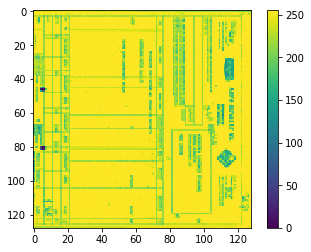

In [10]:
#Plot sample image with scale
plt.imshow(x_train[0])
plt.colorbar()

In [11]:
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, imgRows, imgCols)
    x_test = x_test.reshape(x_test.shape[0], 1, imgRows, imgCols)
    input_shape = (1, imgRows, imgCols)
else:
    x_train = x_train.reshape(x_train.shape[0], imgRows, imgCols, 1)
    x_test = x_test.reshape(x_test.shape[0], imgRows, imgCols, 1)
    input_shape = (imgRows, imgCols, 1)

In [12]:
x_train = x_train.astype('float32') #convert interger image tensor to float
x_test = x_test.astype('float32') #convert interger image tensor to float
x_train = x_train/255 # Normalize grayscale to a number between 0 and 1
x_test = x_test/255 # Normalize grayscale to a number between 0 and 1
# convert class vectors to binary class matrices (One-hot encoding)
y_train = keras.utils.to_categorical(y_train, NClasses) 
y_test = keras.utils.to_categorical(y_test, NClasses)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11379 train samples
4877 test samples


## 3. Setup CNN Model

In [13]:
ModelID='DocumentClassification_IBM_ADV_DS_Capstone'
ModelVersion = 'CNN_V03' # 'LGR_V01' #    'DFF_V01' #    'CNN_V01' #   'CNN_V02' # 
batch_size = 64 # 128 was used in GPU development environment (delivered model)
epochs = 10 # 40 was used in GPU development environment (delivered model)
optimizer=keras.optimizers.Adadelta()
BuiltDate= '20190316' #date.today().strftime('%Y%m%d')
ModelFileName = '{}_{}_{}x{}_{}'.format(ModelID, ModelVersion, imgRows, imgCols, BuiltDate)
print('Building Model {}'.format(ModelFileName))

Building Model DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316


In [14]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape)) #, strides=(2, 2)
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu')) 
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu')) 
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(NClasses, activation='softmax')) # Output layer

### model summary

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
__________

### Compile model 

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


## 4. Fit Model

In [17]:
# Create Tensorflow Session
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16))
keras.backend.set_session(sess)

# Fit model
hist = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test))


Train on 11379 samples, validate on 4877 samples
Epoch 1/10
11379/11379 [==============================] - 439s 39ms/step - loss: 1.6115 - acc: 0.2876 - val_loss: 1.4241 - val_acc: 0.4515
Epoch 2/10
11379/11379 [==============================] - 437s 38ms/step - loss: 1.2580 - acc: 0.5218 - val_loss: 0.8318 - val_acc: 0.6974
Epoch 3/10
11379/11379 [==============================] - 437s 38ms/step - loss: 0.8642 - acc: 0.6994 - val_loss: 0.6825 - val_acc: 0.7591
Epoch 4/10
11379/11379 [==============================] - 435s 38ms/step - loss: 0.6632 - acc: 0.7734 - val_loss: 0.6424 - val_acc: 0.7792
Epoch 5/10
11379/11379 [==============================] - 435s 38ms/step - loss: 0.5100 - acc: 0.8322 - val_loss: 0.5027 - val_acc: 0.8321
Epoch 6/10
11379/11379 [==============================] - 435s 38ms/step - loss: 0.4004 - acc: 0.8677 - val_loss: 0.4374 - val_acc: 0.8651
Epoch 7/10
11379/11379 [==============================] - 434s 38ms/step - loss: 0.3295 - acc: 0.8945 - val_loss: 0.4

Text(0.5, 0, 'Epocs')

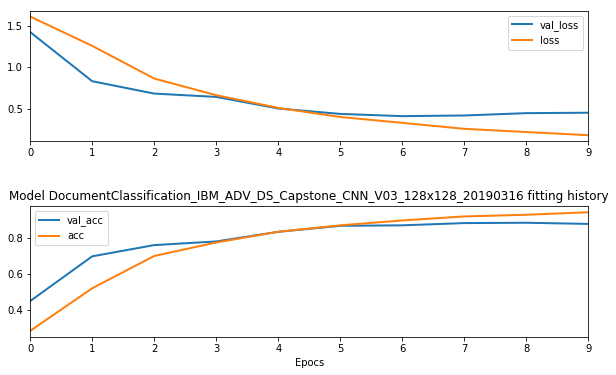

In [19]:
ModelHistory = pd.DataFrame(data = hist.history)
# Plot model history and save           
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.subplots_adjust(hspace=0.5)
ModelHistory[['val_loss', 'loss']].plot(linewidth=2, figsize=(10, 6), ax=axes[0])
ModelHistory[['val_acc', 'acc']].plot(linewidth=2, figsize=(10, 6),ax=axes[1])
plt.title('Model {} fitting history'.format(ModelFileName))
plt.xlabel('Epocs')

## 5. Analyze model fitting History and Evaluate Performance

In [20]:
# Print model fitting summury 
score = model.evaluate(x_test, y_test, verbose=0)    
print(ModelFileName)
print(model.summary())
print('train samples:', x_train.shape[0])
print('test samples:', x_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        18496     
_________________________________________________________________
max_pool

## 6. Save Model

In [21]:
model.save('{}.h5'.format(ModelFileName))
print('TF Model {}.h5 is saved...'.format(ModelFileName))

TF Model DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316.h5 is saved...


## 7. Test saved model

In [28]:
ModelLoaded = keras.models.load_model('{}.h5'.format(ModelFileName))     
predictions_test = ModelLoaded.predict(x_test)    

N  =len(predictions_test)
PredictedClassNumbers = [None] * N
PredictedClassConfidence = [None] * N
ActualClassNumbers = [None] * N

for i in range(N):
    p = np.argmax(predictions_test[i])
    PredictedClassNumbers[i] = p
    PredictedClassConfidence[i] = predictions_test[i][p]  

for i in range(N):
    p = np.argmax(y_test[i])
    ActualClassNumbers[i] = p

TestResults = pd.DataFrame(data = predictions_test)
TestResults['PredictedClassNumber'] = PredictedClassNumbers
TestResults['ActualClassNumber'] = ActualClassNumbers

### Print model fitting summary and performance

In [24]:
print(ModelFileName)
print('train samples:', x_train.shape[0])
print('test samples:', x_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])    
print(pd.crosstab(TestResults['ActualClassNumber'], TestResults['PredictedClassNumber'],  margins=True))   

DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316
train samples: 11379
test samples: 4877
Test loss: 0.45174278787885114
Test accuracy: 0.8755382407584199
PredictedClassNumber    0    1    2    3    4    5   All
ActualClassNumber                                       
0                     720   14   30    6    4    7   781
1                       9  727   47   12    0    0   795
2                      34   41  717   39   10    6   847
3                       9   26   61  761   16   13   886
4                       0    7   31   57  696   16   807
5                      25    3   47   24   13  649   761
All                   797  818  933  899  739  691  4877


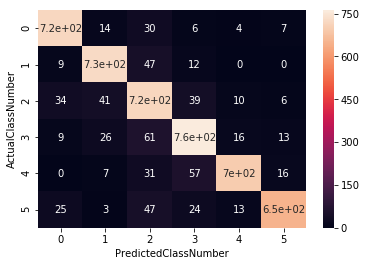

In [25]:
import seaborn as sns
sns.heatmap(pd.crosstab(TestResults.ActualClassNumber, TestResults.PredictedClassNumber, margins=False), annot=True)

<hr>
<p> This notebook and related materials were developed by <b> Sumudu Tennakoon</b> for the capstone project in partial fulfillment of the requirements for the <b> Advanced Data Science with IBM Specialization</b>. <br>
March 2019. <br>
Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)</p>